In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *

d:\Workspace\vinicius\Programs\Miniforge23\envs\diffae\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


# Interpolation of images aligned by flow-net

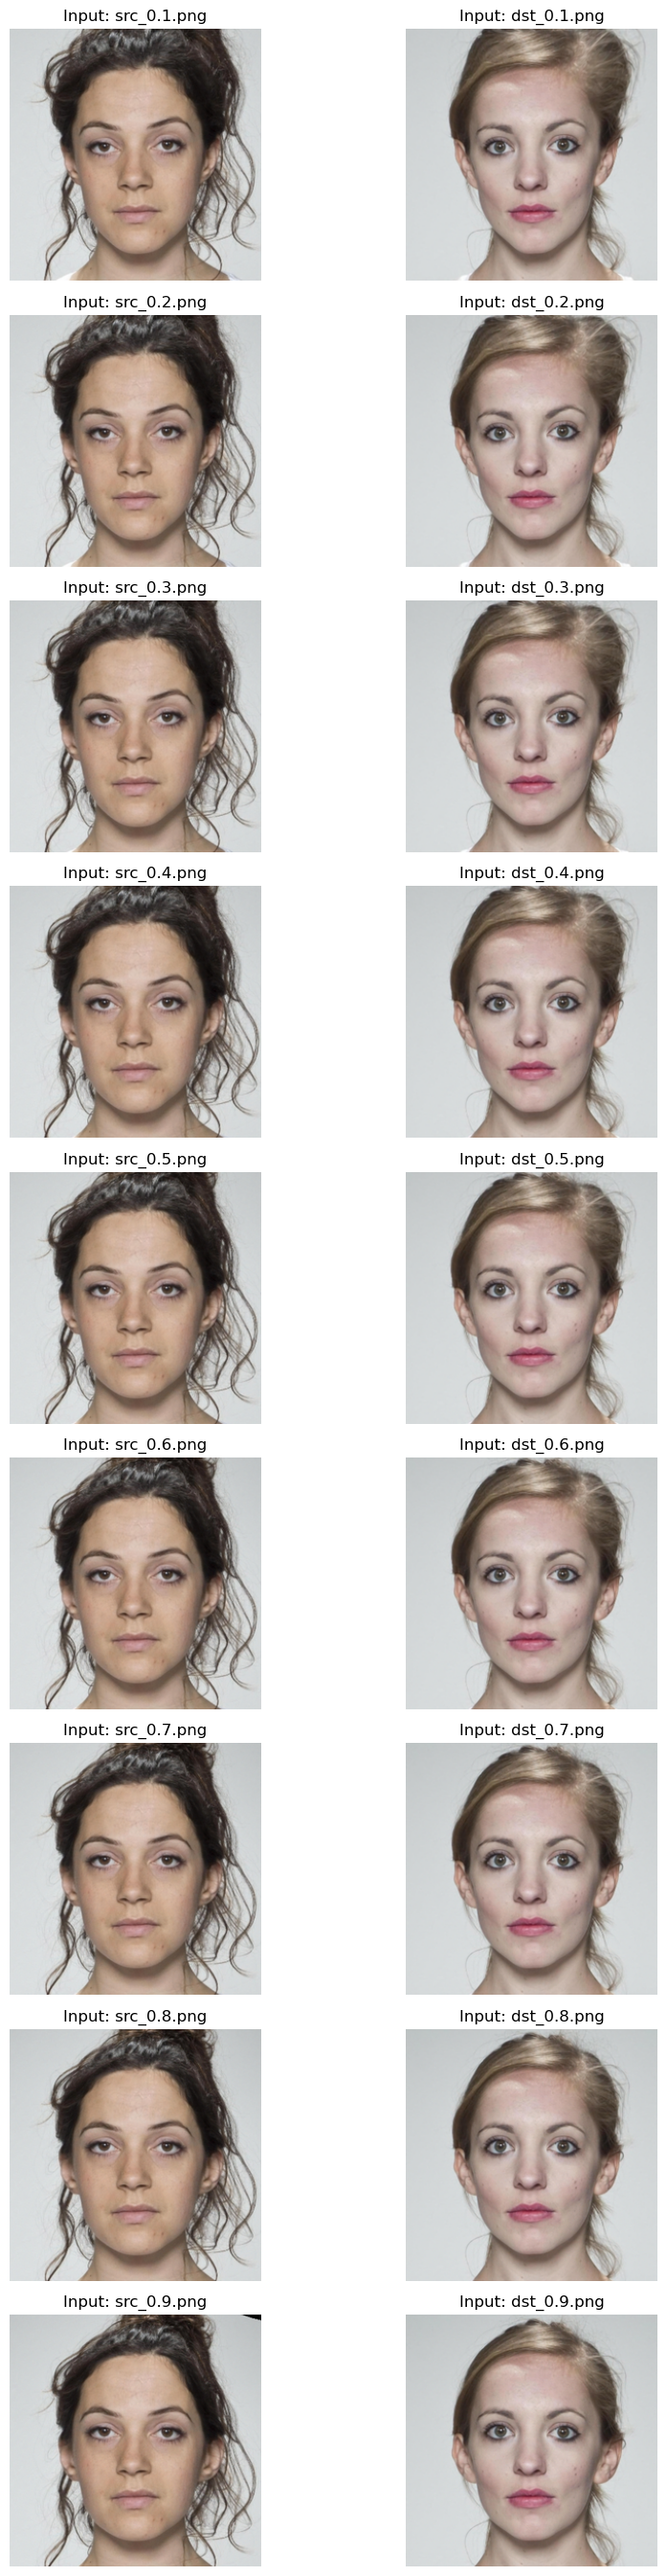

In [4]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Normalize, Compose

# 1. Load the Aligned Images
image_folder = 'imgs_crop'  # Replace this with your folder path
timestamps = np.arange(0.0, 1.1, 0.1)
#alpha = torch.tensor(np.linspace(0, 1, 10, dtype=np.float32)).to(src_cond.device)

def load_image_pair(timestamp, image_folder):
    src_img_path = os.path.join(image_folder, f'src_{timestamp:.1f}.png')
    dst_img_path = os.path.join(image_folder, f'dst_{timestamp:.1f}.png')
    
    src_img = Image.open(src_img_path)
    dst_img = Image.open(dst_img_path)
    
    return src_img, dst_img

src_images = []
dst_images = []

# Plotting the image pairs
fig, axes = plt.subplots(len(timestamps), 2, figsize=(10, 3 * len(timestamps)))

for i, timestamp in enumerate(timestamps):
    src_img, dst_img = load_image_pair(timestamp, image_folder)
    
    src_images.append(src_img)
    dst_images.append(dst_img)

    # Handling the single-row case
    if len(timestamps) == 1:
        current_axes = [axes[0], axes[1]]
    else:
        current_axes = axes[i]
    
    current_axes[0].imshow(src_img)
    current_axes[0].set_title(f'Input: src_{timestamp:.1f}.png')
    current_axes[0].axis('off')
    
    current_axes[1].imshow(dst_img)
    current_axes[1].set_title(f'Input: dst_{timestamp:.1f}.png')
    current_axes[1].axis('off')

plt.tight_layout()
plt.show()

In [5]:
transform = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Lists to store the encodings for each pair
src_semantic_encodings = []
dst_semantic_encodings = []
src_stochastic_encodings = []
dst_stochastic_encodings = []

for i, timestamp in enumerate(timestamps):
    # Convert the PIL images to tensors and normalize them
    src_img_tensor = transform(src_images[i]).unsqueeze(0).to(device)
    dst_img_tensor = transform(dst_images[i]).unsqueeze(0).to(device)
    
    # Encode the Images
    src_cond = model.encode(src_img_tensor)
    dst_cond = model.encode(dst_img_tensor)
    
    src_xT = model.encode_stochastic(src_img_tensor, src_cond, T=250)
    dst_xT = model.encode_stochastic(dst_img_tensor, dst_cond, T=250)
    
    # Append the encodings to the lists
    src_semantic_encodings.append(src_cond[0])
    dst_semantic_encodings.append(dst_cond[0])
    src_stochastic_encodings.append(src_xT[0])
    dst_stochastic_encodings.append(dst_xT[0])


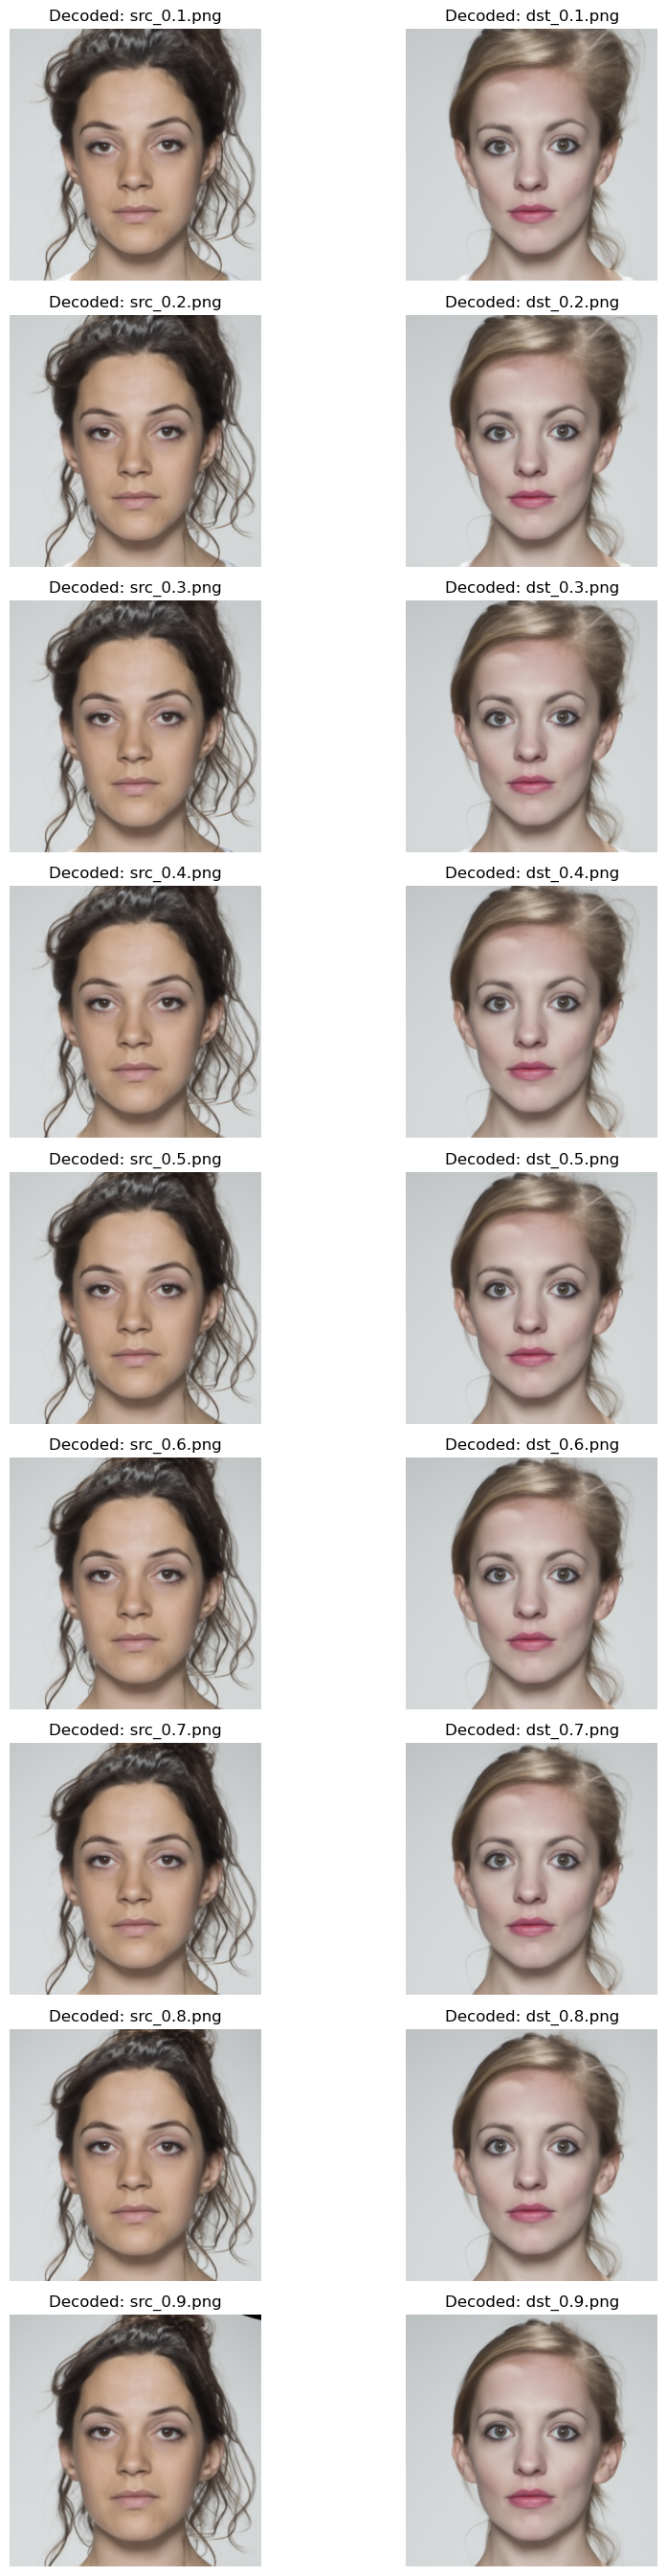

In [6]:
# Lists to store the rendered images for each encoded pair
rendered_src_images = []
rendered_dst_images = []

fig, axes = plt.subplots(len(timestamps), 2, figsize=(10, 3 * len(timestamps)))

for i, timestamp in enumerate(timestamps):
    # Retrieve the stored encodings
    src_cond = src_semantic_encodings[i]
    dst_cond = dst_semantic_encodings[i]
    
    src_xT = src_stochastic_encodings[i]
    dst_xT = dst_stochastic_encodings[i]
    
    # Render the Images from the Encodings
    rendered_src = model.render(src_xT[None], src_cond[None], T=20)[0]
    rendered_dst = model.render(dst_xT[None], dst_cond[None], T=20)[0]
    
    # Append to lists
    rendered_src_images.append(rendered_src)
    rendered_dst_images.append(rendered_dst)
    
    # Handling the single-row case
    if len(timestamps) == 1:
        current_axes = [axes[0], axes[1]]
    else:
        current_axes = axes[i]
    
    # Plot the Original and Rendered Images Side-by-Side
    current_axes[0].imshow(rendered_src.cpu().numpy().transpose(1, 2, 0))
    current_axes[0].set_title(f'Decoded: src_{timestamp:.1f}.png')
    current_axes[0].axis('off')
    
    current_axes[1].imshow(rendered_dst.cpu().numpy().transpose(1, 2, 0))
    current_axes[1].set_title(f'Decoded: dst_{timestamp:.1f}.png')
    current_axes[1].axis('off')

plt.tight_layout()
plt.show()

Semantic codes are interpolated using convex combination, while stochastic codes are interpolated using spherical linear interpolation.

In [7]:
# Lists to store all interpolated images for each pair
all_interpolated_images = []

def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

for i, timestamp in enumerate(timestamps):
    # Retrieve the stored encodings
    src_cond = src_semantic_encodings[i]
    dst_cond = dst_semantic_encodings[i]

    src_xT = src_stochastic_encodings[i]
    dst_xT = dst_stochastic_encodings[i]
    
    timestamps_gpu = torch.tensor(timestamps).type(torch.HalfTensor).to(device=device)

    # Interpolate the Codes
    semantic_intp = src_cond[None] * (1 - timestamps_gpu[i, None]) + dst_cond[None] * timestamps_gpu[i, None]

    #print(f'Alpha: {alpha}')
    #print(f'Semantic Intp: {semantic_intp}')

    # Normalize to avoid values outside the arccos expected parameter range [-1, 1]
    src_xT_normalized = src_xT / torch.norm(src_xT)
    dst_xT_normalized = dst_xT / torch.norm(dst_xT)

    dot_product = (src_xT_normalized * dst_xT_normalized).sum()
    theta = torch.arccos(dot_product)
    x_shape = src_xT.shape
    stochastic_intp = (torch.sin((1 - timestamps_gpu[i, None]) * theta) * src_xT.flatten(0, 2)[None] + torch.sin(timestamps_gpu[i, None] * theta) * dst_xT.flatten(0, 2)[None]) / torch.sin(theta)
    stochastic_intp = stochastic_intp.view(-1, *x_shape)

    #print(f'Dot product: {dot_product}')
    #print(f'Theta: {theta}')
    #print(f'Stochastic Intp: {stochastic_intp}')

    # Render the Interpolated Images
    interpolated_images = model.render(stochastic_intp, semantic_intp, T=20)
    all_interpolated_images.append(interpolated_images)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


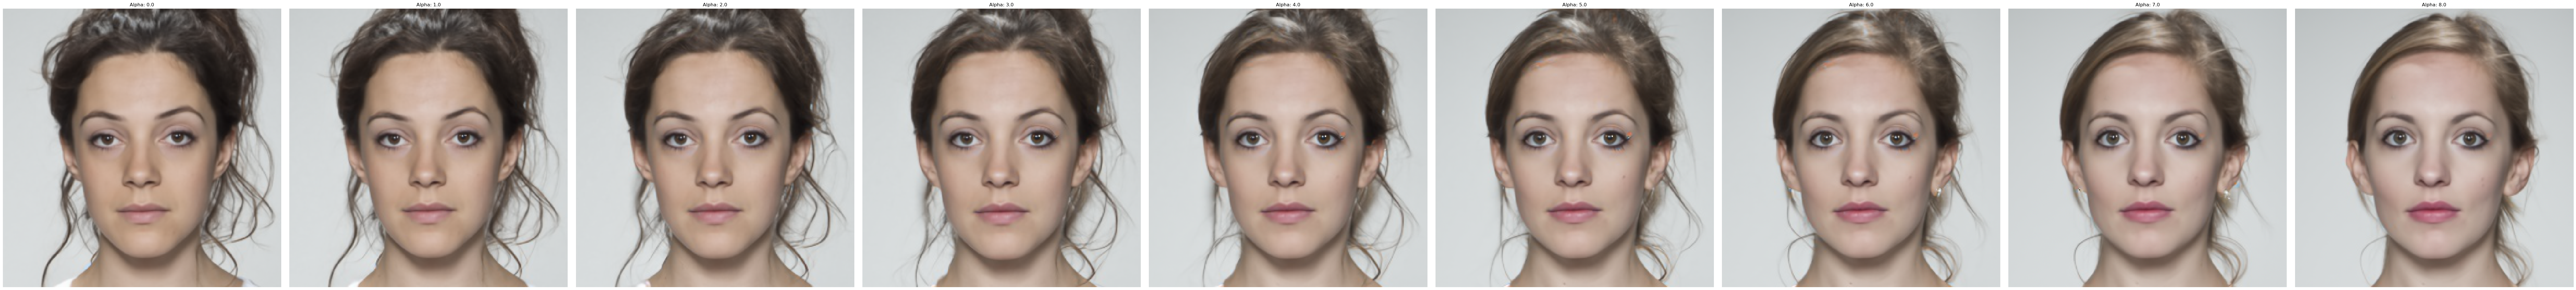

In [8]:
# Function to plot the interpolated images
def plot_interpolated_images(all_interpolated_images, timestamps):
    # Number of interpolation stages
    num_stages = len(all_interpolated_images)
    
    # Create a grid for plotting
    fig, axes = plt.subplots(1, len(all_interpolated_images), figsize=(10*9, 10))

    for i, interpolated_images in enumerate(all_interpolated_images):
        #for j, img_tensor in enumerate(interpolated_images):
        # Convert tensor image to numpy array for plotting
        img_tensor = interpolated_images.squeeze(0)
        print(img_tensor.shape)
        img_array = img_tensor.cpu().detach().numpy().transpose(1, 2, 0)   # De-normalize

        #min_value = img_tensor.min().item()
        #max_value = img_tensor.max().item()
        #print(f"Interpolated Image [{i}, {i}] - Min Value: {min_value}, Max Value: {max_value}")

        #ax = axes[i][j] if len(timestamps) > 1 else axes[j]
        ax = axes[i]
        ax.imshow(img_array)
        ax.axis('off')
        #if i == 0:
        #ax.set_title(f'Alpha: {j / (num_stages-1):.1f}')
        ax.set_title(f'Alpha: {i:.1f}')
    
    plt.tight_layout()
    plt.show()

# Plotting the interpolated images
plot_interpolated_images(all_interpolated_images, timestamps)